## Import

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
import matplotlib.pyplot as plt
from googletrans import Translator

## Data Load

In [9]:
# ✅ 학습 장치 설정: CUDA, MPS, CPU 자동 선택
device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cpu")
)
print(f"Using device: {device}")

# ✅ 데이터 로드
train_df = pd.read_csv("//Users/jian_lee/Desktop/aiffel/data/aiffel-dl-thon-dktc-online-12/data/train.csv")
test_df = pd.read_csv("/Users/jian_lee/Desktop/aiffel/data/aiffel-dl-thon-dktc-online-12/data/test.csv")

Using device: mps


## 데이터 전처리

### Data Augmentation

In [10]:
# ✅ 텍스트 컬럼 강제 변환 (float 방지)
train_df["text"] = train_df["text"].fillna("").astype(str)
test_df["text"] = test_df["text"].fillna("").astype(str)

# ✅ Back Translation (Google 번역 API 활용)
translator = Translator()

def back_translate(text):
    """Google 번역 API를 이용한 Back Translation (한글 → 영어 → 한글)"""
    try:
        english_text = translator.translate(text, src="ko", dest="en").text
        translated_text = translator.translate(english_text, src="en", dest="ko").text
        return translated_text
    except:
        return text  # 번역 실패 시 원문 반환

# ✅ Noise Injection (랜덤 문자 추가)
def inject_noise(text, noise_ratio=0.1):
    """문장에 랜덤하게 오타(문자 변경)를 삽입하는 함수"""
    if not isinstance(text, str):  # 문자열이 아닐 경우 변환
        text = str(text)
    
    text = list(text)
    num_noises = int(len(text) * noise_ratio)
    for _ in range(num_noises):
        idx = random.randint(0, len(text) - 1)
        text[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")  # 랜덤 문자 삽입
    return "".join(text)

# ✅ 데이터 증강 적용 (5% 샘플에 적용)
augmented_texts = []
augmented_labels = []

for _, row in train_df.sample(frac=0.05, random_state=42).iterrows():
    original_text = row["text"]
    label = row["class"]

    # Back Translation
    back_translated_text = back_translate(original_text)
    augmented_texts.append(back_translated_text)
    augmented_labels.append(label)

    # Noise Injection
    noisy_text = inject_noise(original_text)
    augmented_texts.append(noisy_text)
    augmented_labels.append(label)

# ✅ 증강 데이터 추가
aug_df = pd.DataFrame({"text": augmented_texts, "class": augmented_labels})
train_df = pd.concat([train_df, aug_df], ignore_index=True)

# ✅ 변환 완료된 데이터 확인
print(f"🔹 데이터 증강 완료: 총 {len(train_df)}개 샘플")
print(train_df.head())

🔹 데이터 증강 완료: 총 5446개 샘플
   idx  class                                               text
0  0.0      0  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1  1.0      0  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2  2.0      3  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3  3.0      1  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4  4.0      1  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


## Dataset 클래스 정의

In [11]:
# ✅ TextDataset 클래스 정의
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128, is_test=False):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = self.dataframe.iloc[index]["text"]
        inputs = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )

        if self.is_test:
            return {
                "input_ids": inputs["input_ids"].squeeze(0),
                "attention_mask": inputs["attention_mask"].squeeze(0),
            }
        
        label = int(self.dataframe.iloc[index]["class"])  # 이미 숫자로 변환된 상태
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

## 모델 및 데이터 준비

In [12]:
# ✅ 모델 및 토크나이저 설정
MODEL_NAME = "monologg/koelectra-base-v3-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(train_df["class"].unique()))
model.to(device)

# ✅ Train-Test 데이터 분할
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["class"])
train_dataset = TextDataset(train_data, tokenizer)
valid_dataset = TextDataset(valid_data, tokenizer)
test_dataset = TextDataset(test_df, tokenizer, is_test=True)

# ✅ 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 학습 루프 및 손실값 시각화

In [13]:
# ✅ Optimizer 및 손실 함수 정의
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)  # AdamW 옵티마이저
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss (다중 분류)

# ✅ 학습 루프 및 손실값 저장
EPOCHS = 10
train_losses, valid_losses = [], []
train_f1_scores, valid_f1_scores = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(all_labels, all_preds, average="macro")
    train_losses.append(total_loss)
    train_f1_scores.append(train_f1)

    # ✅ 검증
    model.eval()
    valid_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in valid_loader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    valid_f1 = f1_score(all_labels, all_preds, average="macro")
    valid_losses.append(valid_loss)
    valid_f1_scores.append(valid_f1)

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Train F1: {train_f1:.4f} | Valid Loss: {valid_loss:.4f} | Valid F1: {valid_f1:.4f}")

/Users/jian_lee/Desktop/.venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Train Loss: 313.7603 | Train F1: 0.1352 | Valid Loss: 76.5240 | Valid F1: 0.0717
Epoch 2 | Train Loss: 300.7656 | Train F1: 0.1855 | Valid Loss: 75.0919 | Valid F1: 0.1660
Epoch 3 | Train Loss: 290.6395 | Train F1: 0.2567 | Valid Loss: 69.7814 | Valid F1: 0.3654
Epoch 4 | Train Loss: 243.2936 | Train F1: 0.3686 | Valid Loss: 57.7956 | Valid F1: 0.3809
Epoch 5 | Train Loss: 201.4995 | Train F1: 0.4333 | Valid Loss: 49.6444 | Valid F1: 0.4598
Epoch 6 | Train Loss: 169.1118 | Train F1: 0.4900 | Valid Loss: 43.1923 | Valid F1: 0.4903
Epoch 7 | Train Loss: 140.1119 | Train F1: 0.5358 | Valid Loss: 39.6679 | Valid F1: 0.5220
Epoch 8 | Train Loss: 117.2513 | Train F1: 0.5726 | Valid Loss: 36.4958 | Valid F1: 0.5500
Epoch 9 | Train Loss: 95.8171 | Train F1: 0.5990 | Valid Loss: 36.1516 | Valid F1: 0.5534
Epoch 10 | Train Loss: 79.7645 | Train F1: 0.6235 | Valid Loss: 35.4756 | Valid F1: 0.5634


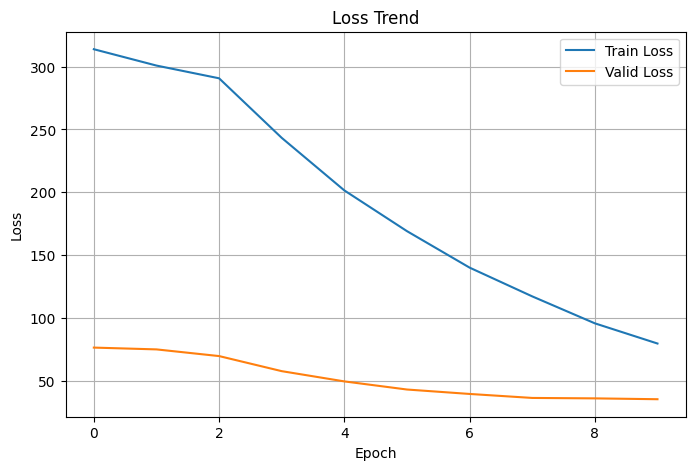

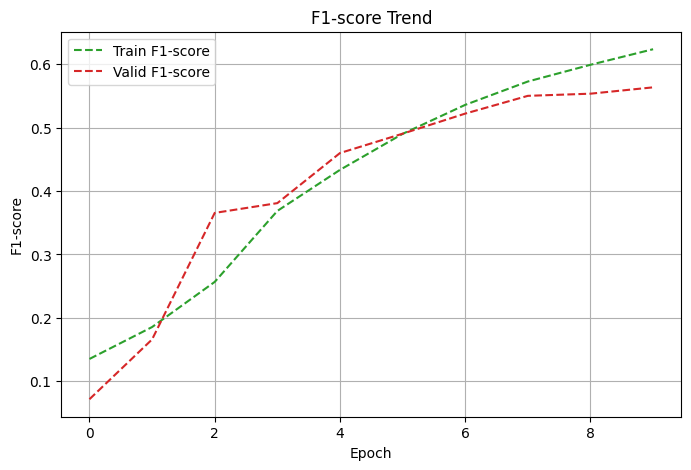

In [14]:
# ✅ 학습 과정 시각화 (Loss & F1-score)

# ✅ Loss 그래프
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="tab:blue")
plt.plot(valid_losses, label="Valid Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Trend")
plt.legend()
plt.grid()
plt.show()

# ✅ F1-score 그래프
plt.figure(figsize=(8, 5))
plt.plot(train_f1_scores, label="Train F1-score", color="tab:green", linestyle="--")
plt.plot(valid_f1_scores, label="Valid F1-score", color="tab:red", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("F1-score Trend")
plt.legend()
plt.grid()
plt.show()

## submission

In [19]:
import os

# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print(f"📌 현재 작업 디렉토리: {current_dir}")

# 파일을 현재 디렉토리에 저장하도록 변경
submission_path = os.path.join(current_dir, "submission.csv")
submission.to_csv(submission_path, index=False)
print(f"✅ 테스트 예측 완료! 결과가 {submission_path}에 저장되었습니다.")

📌 현재 작업 디렉토리: /Users/jian_lee/Desktop/aiffel/data/aiffel-dl-thon-dktc-online-12
✅ 테스트 예측 완료! 결과가 /Users/jian_lee/Desktop/aiffel/data/aiffel-dl-thon-dktc-online-12/submission.csv에 저장되었습니다.
